In [ ]:
# %%bash
# pip install lightfm

In [1]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn import model_selection
from scipy.sparse import coo_matrix
from scipy import sparse
from time import time
import matplotlib.pyplot as plt
import csv

import numpy as np
import pandas as pd

# from google.colab import files

/Users/joshfeldman/Desktop/Projects/personalization_project/venv/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Util

In [2]:
def downloadCSVFile(listOfDicts, fileName):
    resultDF = pd.DataFrame(listOfDicts)
    resultDF.to_csv(fileName)
#   files.download(fileName)

##Get Data

In [3]:
# %%bash
# mkdir -p 'results'

# rm ratings.csv

In [4]:
# # Upload ratings.csv

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

### Make Train, Validate, Test

In [5]:
# ratingsDataPath = 'data-medium/ratings_5550689.csv'
# ratingsDataPath = 'data-medium/ratings_1387672.csv'
ratingsDataPath = 'data-medium/ratings_13876722.csv'
# ratingsDataPath = 'ml-latest-small/ratings.csv'

ratingsDF = pd.read_csv(ratingsDataPath)
ratingsDF = ratingsDF[['userId', 'movieId', 'rating']]

print('We have {} ratings total'.format(len(ratingsDF)))

# Alter ratings to work better for our model
ratingsDF['rating'] = ratingsDF['rating'].apply(lambda x: x - 2.9)

userIds = ratingsDF['userId'].unique().astype('int32')
movieIds = ratingsDF['movieId'].unique().astype('int32')

print('We have {} users'.format(len(userIds)))
print('We have {} movies'.format(len(movieIds)))

movieIdToIndex = {}
for index, movieId in enumerate(movieIds):
    movieIdToIndex[movieId] = index

userIdToIndex = {}
for index, userId in enumerate(userIds):
    userIdToIndex[userId] = index

ratingsTrainDF, ratingsTestDF = model_selection.train_test_split(ratingsDF, test_size=0.2, random_state=324)
ratingsTrainGridSearchDF, ratingsValidateGridSearchDF = model_selection.train_test_split(ratingsTrainDF, test_size=0.2, random_state=773)

print('We have {} train ratings'.format(len(ratingsTrainDF)))
print('We have {} test ratings'.format(len(ratingsTestDF)))
print('We have {} grid search train ratings'.format(len(ratingsTrainGridSearchDF)))
print('We have {} grid search validate ratings'.format(len(ratingsValidateGridSearchDF)))


We have 13876722 ratings total
We have 278304 users
We have 46491 movies
We have 11101377 train ratings
We have 2775345 test ratings
We have 8881101 grid search train ratings
We have 2220276 grid search validate ratings


In [6]:
ratingsTrainDF.head()

,userId,movieId,rating
8114862,18250,3252,1.1
5499116,9698,5546,-2.4
9188073,221741,3949,0.6
3458186,274455,31696,1.1
5738893,82514,52604,0.6


### Convert to Matrix

In [7]:
def ratingsDFToUserMovieMatrix(ratingsDF, userIdToIndex, movieIdToIndex):
    numUsers = len(userIdToIndex)
    numMovies = len(movieIdToIndex)
    
#     startTime = time()
#     mat = sparse.coo_matrix((ratingsDF["rating"], (ratingsDF["userId"], ratingsDF["movieId"])))
#     result1 = mat
#     totalTime = time() - startTime
#     print('Method 1 takes {} seconds'.format(totalTime))
#     print(result1.todense())
#     print('Shape: {}'.format(result1.shape))
#     print('')

#     startTime = time()
#     ratingsDF2 = ratingsDF.copy()
#     numRatings = len(ratingsDF)
#     usersInDF = set(ratingsDF['userId'])
#     for user in userIds:
#         if user not in usersInDF:
#             ratingsDF2.loc[numRatings] = 0
#             numRatings += 1
#     moviesInDF = set(ratingsDF['movieId'])
#     for movie in movieIds:
#         if movie not in moviesInDF:
#             ratingsDF2.loc[numRatings] = 0
#             numRatings += 1
        
#     userItemDF = ratingsDF2.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)#.fillna(0)
#     result2 = coo_matrix(userItemDF.values)
#     totalTime = time() - startTime
#     print('Method 2 takes {} seconds'.format(totalTime))
#     print(result2.todense())
#     print('Shape: {}'.format(result2.shape))
#     print('')

    startTime = time()
    userMovieMatrix = np.zeros((numUsers, numMovies))
    for index, row in ratingsDF.iterrows():
        userId = int(row['userId'])
        movieId = int(row['movieId'])
        rating = float(row['rating'])

        userIndex = userIdToIndex[userId]
        movieIndex = movieIdToIndex[movieId]
        userMovieMatrix[userIndex, movieIndex] = rating
    result3 = sparse.coo_matrix(userMovieMatrix)
    totalTime = time() - startTime
#     print('')
#     print('Method 3 takes {} seconds'.format(totalTime))
        
#     print('Method 1 and 2: {}'.format(result1 == result2))
#     print('Method 2 and 3: {}'.format(result2 == result3))
    
    return result3


#     return coo_matrix(userMovieMatrix)


XTrain = ratingsDFToUserMovieMatrix(ratingsTrainGridSearchDF, userIdToIndex, movieIdToIndex)
print('Shape of X Train: {}'.format(XTrain.shape))
XValidate = ratingsDFToUserMovieMatrix(ratingsValidateGridSearchDF, userIdToIndex, movieIdToIndex)
print('Shape of X Validate: {}'.format(XValidate.shape))
XTest = ratingsDFToUserMovieMatrix(ratingsTestDF, userIdToIndex, movieIdToIndex)
print('Shape of X Test: {}'.format(XTest.shape))

Shape of X Train: (278304, 46491)
Shape of X Validate: (278304, 46491)
Shape of X Test: (278304, 46491)


# Add K-Fold Validation to Grid Search

# Run Grid Search

In [8]:
def runModel(params, XTrain, XTest):
    learningRate = params['learning_rate']
    lossFunction = params['loss']
    learning_schedule = params['learning_schedule']
  
    startTime = time()
  
    model = LightFM(
        learning_rate=learningRate, 
        loss=lossFunction, 
        learning_schedule=learning_schedule, 
        random_state=8362
    )
    model.fit(XTrain, epochs=5)

    totalTime = time() - startTime

    # Evaluate the trained model
    #   test_precision = precision_at_k(model, XTest, k=10).mean()
    #   test_recall = recall_at_k(model, XTest, k=10).mean()
    train_auc = auc_score(model, XTrain).mean()
    test_auc = auc_score(model, XTest).mean()

    return train_auc, test_auc, totalTime

In [9]:
gridSearchParams = {
    'learning_rate': [0.05],
    'loss': ['logistic', 'bpr', 'warp', 'warp-kos'],
#     'loss': ['bpr'],
    'learning_schedule': ['adagrad', 'adadelta'],
}

def gridSearch(gridSearchParams):
  
    results = []
  
    for learningRate in gridSearchParams['learning_rate']:
        for lossFunction in gridSearchParams['loss']:
            for learning_schedule in gridSearchParams['learning_schedule']:
                params = {
                    'learning_rate': learningRate,
                    'loss': lossFunction,
                    'learning_schedule': learning_schedule,
                }
                print('Running for params: {}'.format(params))
                train_auc, test_auc, totalTime = runModel(params, XTrain, XValidate)
                params['train_auc'] = train_auc
                params['test_auc'] = test_auc
                params['time'] = totalTime
                results.append(params)
        
    print(results)
    downloadCSVFile(results, 'gridSearchResults.csv')
    return results

In [ ]:
startTime = time()

gridSearchResults = gridSearch(gridSearchParams)

totalTime = time() - startTime
if totalTime > 60:
    print('Total time: {:0.2f} minutes'.format(totalTime / 60))
else:
    print('Total time: {:0.2f} seconds'.format(totalTime))

Running for params: {'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adagrad'}
Running for params: {'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adadelta'}
Running for params: {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adagrad'}
Running for params: {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adadelta'}
Running for params: {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adagrad'}
Running for params: {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adadelta'}
Running for params: {'learning_rate': 0.05, 'loss': 'warp-kos', 'learning_schedule': 'adagrad'}
Running for params: {'learning_rate': 0.05, 'loss': 'warp-kos', 'learning_schedule': 'adadelta'}
[{'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adagrad', 'train_auc': 0.90176773, 'test_auc': 0.9065967, 'time': 41.997424840927124}, {'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adadelta', 'train_auc': 0.

In [ ]:
def extractBestParams(gridSearchResults):
    bestIndex = 0
    bestAUC = gridSearchResults[0]['test_auc']

    for index, results in enumerate(gridSearchResults):
        if results['test_auc'] > bestAUC:
            bestAUC = results['test_auc']
            bestIndex = index

    bestParams = {}
    for param, value in gridSearchResults[bestIndex].items():
        if param in ['train_auc', 'test_auc', 'time']:
            continue
        bestParams[param] = value

    print('Best AUC is: {}'.format(bestAUC))
    return bestParams

bestParams = extractBestParams(gridSearchResults)
bestParams

Best AUC is: 0.9836653470993042


{'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp'}

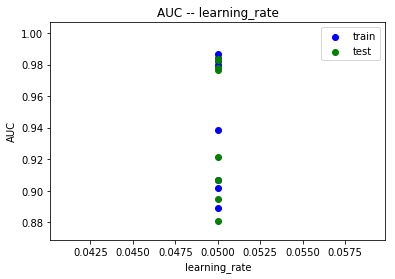

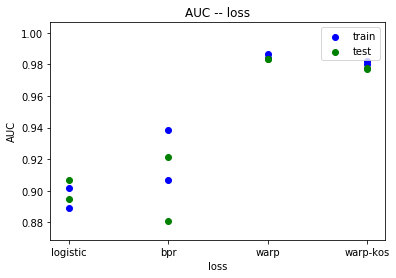

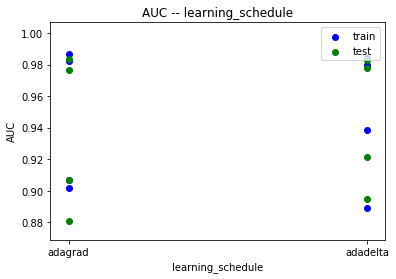

In [ ]:
def plotGridSearchResults(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    for param in gridSearchParams.keys():
        plt.scatter(gridSearchDF[param], gridSearchDF['train_auc'], color='blue')
        plt.scatter(gridSearchDF[param], gridSearchDF['test_auc'], color='green')
        plt.title('AUC -- {}'.format(param))
        plt.ylabel('AUC')
        plt.xlabel(param)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

plotGridSearchResults(gridSearchResults)

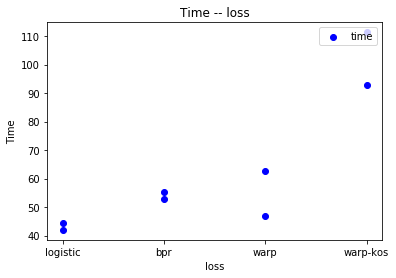

In [ ]:
def plotGridSearchTime(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    plt.scatter(gridSearchDF['loss'], gridSearchDF['time'], color='blue')
    plt.title('Time -- {}'.format('loss'))
    plt.ylabel('Time')
    plt.xlabel('loss')
    plt.legend(['time'], loc='upper right')
    plt.show()

plotGridSearchTime(gridSearchResults)

# Find Best # of Epochs

Write code to check best score in each epoch and then return the best score, not the last score

# Sampling Amount of Data

In [ ]:
dataFractions = np.arange(0.2, 1.2, 0.2)
numRatings = len(ratingsTrainDF)
dataSizes = [int(fraction * numRatings) for fraction in dataFractions]
dataSizes

[2220275, 4440550, 6660826, 8881101, 11101377]

In [ ]:
def sizeSamplingSearch(dataSizes):
    sizeSamplingResults = []

    for numRatings in dataSizes:
        print('')
        print('Running for size: {}'.format(numRatings))
        ratingsTrainDFSampled = ratingsTrainDF.sample(n=numRatings)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndex)
        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XValidate)
        result = {
            'numRatings': numRatings,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        sizeSamplingResults.append(result)

    return sizeSamplingResults

In [ ]:
sizeSamplingResults = sizeSamplingSearch(dataSizes)



Running for size: 2220275

Running for size: 4440550

Running for size: 6660826

Running for size: 8881101

Running for size: 11101377


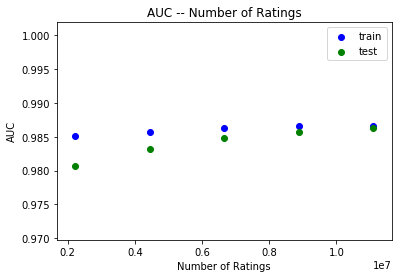

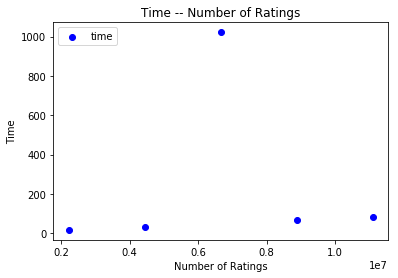

In [ ]:
def plotSizeSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Ratings')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Ratings')
    plt.legend(['time'], loc='upper left')
    plt.show()

plotSizeSamplingResults(sizeSamplingResults)

# Sample By Number of Users

In [ ]:
userFractions = np.arange(0.2, 1.2, 0.2)
numUsers = len(userIds)
userSizes = [int(fraction * numUsers) for fraction in userFractions]
userSizes

[55660, 111321, 166982, 222643, 278304]

In [ ]:
def userSamplingSearch(userSizes):
    userSamplingResults = []

    for numUsers in userSizes:
        print('Running for size: {}'.format(numUsers))
        sampledUserIds = np.random.choice(userIds, numUsers, replace=False)
        userIdToIndexSampled = {}
        for index, userId in enumerate(sampledUserIds):
            userIdToIndexSampled[userId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['userId'].isin(sampledUserIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndexSampled, movieIdToIndex)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndexSampled, movieIdToIndex)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numUsers': numUsers,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        userSamplingResults.append(result)

    return userSamplingResults

In [ ]:
userSamplingResults = userSamplingSearch(userSizes)
userSamplingResults

Running for size: 55660
Running for size: 111321
Running for size: 166982


In [ ]:
def plotUserSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Users')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Users')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotUserSamplingResults(userSamplingResults)

# Sample By Number of Movies

In [ ]:
movieFractions = np.arange(0.2, 1.2, 0.2)
numMovies = len(movieIds)
movieSizes = [int(fraction * numMovies) for fraction in movieFractions]
movieSizes

In [ ]:
def movieSamplingSearch(movieSizes):
    movieSamplingResults = []

    for numMovies in movieSizes:
        print('Running for size: {}'.format(numMovies))
        sampledMovieIds = np.random.choice(movieIds, numMovies, replace=False)
        movieIdToIndexSampled = {}
        for index, movieId in enumerate(sampledMovieIds):
            movieIdToIndexSampled[movieId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['movieId'].isin(sampledMovieIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndexSampled)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndex, movieIdToIndexSampled)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numMovie': numMovies,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        movieSamplingResults.append(result)

    return movieSamplingResults

In [ ]:
movieSamplingResults = movieSamplingSearch(movieSizes)
movieSamplingResults

In [ ]:
def plotMovieSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Movies')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Movies')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotMovieSamplingResults(movieSamplingResults)